## TME 7 Chaine de Markov Caché
### Annotation de gènes par chaînes de Markov Caché

Les modeles de chaines de Markov caché sont tres utilisées notament dans les domaines de la reconnaisance de la parole, du traitement automatique du langage naturel, de la reconnaissance de l'écriture manuscrite et de la bioinformatique.

Les 3 problèmes de bases des HMM (*Hidden Markov Model*) sont :
1. Évaluation : 
 -  Problème : calculer la probabilité d’observation de la séquence d’observations étant donnée un HMM:  
 -  Solution : *Forward Algorithm *

2. Décodage : 
 - Problème : trouver la séquence d’états qui maximise la séquence d’observations 
 - Solution : *Viterbi Algorithm *

3. Entraînement :  
 - Problème : ajuster les paramètres du modèle HMM afin de maximiser la probabilité de générer une séquence d’observations à partir de données d’entraînement  
  - Solution : *Forward-Backward Algorithm*
  

Dans ce TME, nous allons appliquer l'algorithme Viterbi à des données biologiques.

# Rappel de biologie

Dans ce TME, nous allons voir comment les modèles statistiques peuvent être utilisés pour extraire de l'information des données biologiques brutes. Le but sera de spécifier des modèles de Markov cachées qui permettent d'annoter les positions des gènes dans le génome.

Le génome, support de l'information génétique, peut être vu comme une longue séquence de caractères écrite dans un alphabet à 4 lettres: A , C , G et T . Chaque lettre du génome est aussi appelée pair de base (ou bp). Il est maintenant relativement peu coûteux de séquencer un génome (quelques milliers d'euros pour un génome humain). Cependant on ne peut pas comprendre, simplement à partir de la suite de lettres, comment cette information est utilisée par la cellule (un peu comme avoir à disposition un manuel d'instructions écrit dans une langue inconnue).

Un élément essentiel est le gène, qui après transcription et traduction produira les protéines, les molécules responsables de la grande partie de l'activité biochimique des cellules.

La traduction en protéine est faite à l'aide du code génétique qui, à chaque groupe de 3 lettres (ou bp) transcrites fait correspondre un acide aminé. Ces groupes de 3 lettres sont appelés codon et il y en a $4^3$, soit $64$. Donc, en première approximation, un gène est défini par les propriétés suivantes (pour les organismes procaryotes):

- Le premier codon, appelé codon start est ATG,
- Il y a 61 codons qui codent pour la séquence d'acides aminés.
- Le dernier codon, appelé codon stop, marque la fin du gène et est l'une des trois séquences TAA , TAG ou TGA . Il n'apparaît pas dans le gène. 


Nous allons intégrer ces différents éléments d'information pour prédire les positions des gènes. Notez que pour simplifier nous avons omis le fait que la molécule d'ADN est constituée de deux brins complémentaires, et donc que les gènes présents sur le brin complémentaire sont vus "à l'envers" sur notre séquence. Les régions entre les gènes sont appelées les régions intergéniques .

![Image of Yaktocat](https://cdn.kastatic.org/ka-perseus-images/1ade7bbd40ca8dbc7a55ddf4067935e42c347f35.png)

Chacune des séquences de gènes commence par un codon start et fini par un des codons stop. 

# Modélisation de gènes 
## Question 1 : Téléchargement des données

Nous travaillerons sur le premier million de bp du génome de E. coli (souche 042). Plutôt que de travailler avec les lettres A , C , G et T , nous allons les recoder avec des numéros ($A =0$, $C=1$, $G=2$, $T =3$). 

Les annotations fournies sont également codées de $0$ à $3$ :
- 0 si la position est dans une region non codante = region intergenique
- 1 si la position correspond a la position 0 d'un codon
- 2 si la position correspond a la position 1 d'un codon
- 3 si la position correspond a la position 2 d'un codon

In [47]:
# Telechargez le fichier et ouvrez le avec pickle
import numpy as np
import pickle as pkl

Genome=np.load('genome.npy') # Le premier million de bp de E. coli
Annotation=np.load('annotation.npy')# L'annotation sur le genome

## On divise nos donnees, la moitie va nous sevir pour l'apprentissage du modèle
## l'autre partie pour son evaluation

genome_train=Genome[:500000]
genome_test=Genome[500000:]

annotation_train=Annotation[:500000]
annotation_test=Annotation[500000:]
print(genome_train[5000:5020])
print(annotation_train[:20])

[2 0 3 2 0 3 2 0 0 3 1 0 3 1 0 2 3 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Question 2 : Apprentissage 

Comme modèle le plus simple pour séparer les séquences de codons des séquences intergéniques, on va définir la chaîne de Markov caché dont le graphe de transition est donné ci dessous. 

![Image of Yaktocat](http://mapsi.lip6.fr/uploads/Cours/modele1.png)

Un tel modèle se défini de la manière suivante : nous considerons qu'il existe 4 états cachés possibles (intergénique, condon 0, codon 1, condon 2).

On peut rester dans les régions intergéniques, et quand on démarre un gène, la composition de chaque base du codon est différente. Il va falloir, afin de pouvoir utiliser ce modèle pour classifier, connaître les paramètres pour la matrice de transition (donc ici uniquement les probas $a$ et $b$), et les lois $(b_i,i=0,…,3)$ des observations pour les quatre états.

```python
Pi = np.array([1, 0, 0, 0])  ##on commence dans l'intergenique
A =  np.array([[1-a, a  , 0, 0], 
              [0  , 0  , 1, 0],
              [0  , 0  , 0, 1],
              [b  , 1-b, 0, 0 ]])
B = ...

```


Étant donnée la structure d'un HMM (Hidden Markov Chain):

- les observations n'influencent pas les états: les matrices $\Pi$ (distribution de probabilité initiale), $A$ (matrice de transition) s'obtiennent comme dans un modèle de Markov simple (cf semaine 6)
- chaque observation ne dépend que de l'état courant 

La nature des données nous pousse à considérer des lois de probabilités discrètes quelconques pour les émissions. L'idée est donc de procéder par comptage en définissant la matrice $B$ (matrice de probabilités des émissions) comme suit:

- $K$ colonnes (nombre d'observations), $N$ lignes (nombre d'états)
- Chaque ligne correspond à une loi d'émission pour un état (ie, chaque ligne somme à 1) 

Ce qui donne l'algorithme:

1. $b_{ij}$ = comptage des émissions depuis l'état $s_i$ vers l'observation $x_j$
2. normalisation des lignes de $B$ 

Donner le code de la fonction `def learnHMM(allX, allS, N, K):` qui apprend un modèle à partir d'un ensemble de couples (seq. d'observations, seq. d'états) 

In [28]:
def learnHMM(allx, allq, N, K):
    """ apprend un modèle à partir 
    d'un ensemble de couples (seq. d'observations, seq. d'états) 
    retourne les matrices A  B """
    A = np.zeros((N, N)) 
    B = np.zeros((N, K))
    ta = np.where(allq[0 : allq.shape[0] - 1] == 0, 1, 0).sum()
    tb = np.where(allq[0 : allq.shape[0] - 1] == 3, 1, 0).sum()
   
    a = 0
    b = 0
    for i in range(allq.shape[0] - 1):
        if allq[i] == 0 and allq[i+1] == 1:
            a = a + 1
        if allq[i] == 3 and allq[i+1] == 0 :
            b = b + 1
    a = a/ta
    b = b/tb
    A =  np.array([[1-a, a  , 0, 0], 
                   [0  , 0  , 1, 0],
                   [0  , 0  , 0, 1],
                   [b  , 1-b, 0, 0 ]])
    
    for i in range (N):
        allx_i = allx[allq == i]
        for j in range(K):
            B[i, j] = np.where(allx_i == j, 1, 0).sum()/allx_i.shape[0]
            
    print(B.sum(1))
    return A, B
    

In [29]:
Pi = np.array([1, 0, 0, 0])
nb_etat= 4 ## (intergénique, condon 0, codon 1, condon 2)
nb_observation = 4 ## (A,T,C,G)
A,B =learnHMM(genome_train, annotation_train, nb_etat, nb_observation)
print(A)
print(B)

[1. 1. 1. 1.]
[[0.99899016 0.00100984 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.00272284 0.99727716 0.         0.        ]]
[[0.2434762  0.25247178 0.24800145 0.25605057]
 [0.24727716 0.23681872 0.34909315 0.16681097]
 [0.28462222 0.23058695 0.20782446 0.27696637]
 [0.1857911  0.26246354 0.29707437 0.25467098]]


Vous devez trouver 

$A= $
```python
[[0.99899016 0.00100984 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.00272284 0.99727716 0.         0.        ]]
```
$B=$       
```python
[[0.2434762  0.25247178 0.24800145 0.25605057]
 [0.24727716 0.23681872 0.34909315 0.16681097]
 [0.28462222 0.23058695 0.20782446 0.27696637]
 [0.1857911  0.26246354 0.29707437 0.25467098]]
```
        
Notez que ce sont des matrices de probabilites, la somme de chaque ligne donne 1.

## Question 3 :  Estimation la séquence d'états par Viterbi

Il n'est pas toujours évident de trouver les régions codante et non codante d'un genome. Nous souhaiterions annoter automatiquement le génome, c'est-à-dire retrouver **la séquence d'états cachés la plus probable** ayant permis de générer la séquence d'observation.

### Rappels sur l'algorithme Viterbi (1967):

- Il sert à estimer la séquence d'états la plus probable étant donnés les observations et le modèle.
- Il peut servir à approximer la probabilité de la séquence d'observation étant donné le modèle. 

1\. Initialisation (avec les indices à 0 en python): 

$$\begin{array}{ccccccccc} \delta_{0} (i) &=& \log \pi_{i} +\log b_{i} (x_{0}) \\ \Psi_{0}(i) &=& -1 \end{array}$$
 Note: L'initialisation de $\Psi_0(i)$ à $-1$ car $-1$ n'est pas utilisé normalement (n'est pas un état valide).
 
2\. Récursion: 

$$ \begin{array}{ccccccccc} \delta_{t} (j) &=&\displaystyle \left[\max_{i} \delta_{t-1}(i) + \log a_{ij}\right] + \log b_{j}(x_{t}) \\ \Psi_{t}(j) &=&\displaystyle \arg\max_{i\in [1,\ N]} \delta_{t-1} (i) + \log a_{ij} \end{array}$$

3\. Terminaison (indices à {$T-1$} en python) 

$$ S^{\star} = \max_{i} \delta_{T-1}(i)$$

4\. Chemin $$\begin{array}{ccccccccc} s_{T-1}^{\star} & = &\displaystyle \arg\max_{i} \delta_{T-1}(i) \\ s_{t}^{\star} & = & \displaystyle \Psi_{t+1}(s_{t+1}^{\star}) \end{array}$$

L'estimation de $\log p(x_0^{T-1} | \lambda)$ est obtenue en cherchant la plus grande probabilité dans la dernière colonne de $\delta$. Donner le code de la méthode `viterbi(x,Pi,A,B):`

In [44]:
def viterbi(allx,Pi,A,B):
    """
    Parameters
    ----------
    allx : array (T,)
        Sequence d'observations.
    Pi: array, (K,)
        Distribution de probabilite initiale
    A : array (K, K)
        Matrice de transition
    B : array (K, M)
        Matrice d'emission matrix

    """
    ## initialisation
    psi = np.zeros((len(A), len(allx))) # A = N
    psi[:,0]= -1
    delta = np.zeros((len(A), len(allx)))  # initialisation en dimension mais pas en contenu !
    
    for i in range(len(A)):
        delta[i, 0] = np.log(Pi[i]) + np.log(B[ i, allx[0]])
    for t in range(1, len(allx)):
        for j in range(len(A)):
            delta[j, t] = np.max(delta[:, t-1] + np.log(A[:, j]) ) + np.log(B[j, allx[t]])
            psi[j, t] = np.argmax(delta[:, t-1] + np.log(A[:, j]))
    
    T = len(allx)
    sequence = np.zeros(T)
    sequence[T-1] = np.argmax(delta[:, T-1])
    for i in range(T-2, 0, -1):
        sequence[i] = psi[int(sequence[i+1]), i+1]
        
    return sequence
    

In [45]:
etat_predits=viterbi(genome_test,Pi,A,B)


<ipython-input-44-8d578060fd8e>:21: RuntimeWarning: divide by zero encountered in log
  delta[i, 0] = np.log(Pi[i]) + np.log(B[ i, allx[0]])
<ipython-input-44-8d578060fd8e>:24: RuntimeWarning: divide by zero encountered in log
  delta[j, t] = np.max(delta[:, t-1] + np.log(A[:, j]) ) + np.log(B[j, allx[t]])
<ipython-input-44-8d578060fd8e>:25: RuntimeWarning: divide by zero encountered in log
  psi[j, t] = np.argmax(delta[:, t-1] + np.log(A[:, j]))


In [46]:
print(etat_predits[:20])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Affichage
On met les états cachés soit à $0$ (**non codant**) soit à $1$ (**codant**).
```python
etat_predits[etat_predits!=0]=1 
annotation_test[annotation_test!=0]=1
```
puis on affiche pour position du génome si c'est une position codante ou non en utilisant les vrais annotations, puis on affiche pour chaque position si elle est predite comme codante ou non.
```python
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits, label="prediction", ls="--")
plt.legend(loc="best")
plt.show()
```

In [ ]:
import matplotlib.pyplot as plt 
etat_predits2 = etat_predits.copy()
etat_predits[etat_predits!=0]=1 
annotation_test[annotation_test!=0]=1

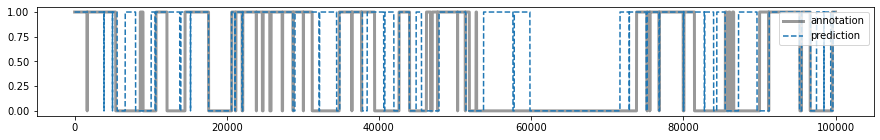

In [52]:

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test[100000:200000], label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits[100000:200000], label="prediction", ls="--")
plt.legend(loc="best")
plt.show()


Vous pouvez considérer une sous partie du génome, par exemple entre 100000 et 200000. Commentez vos observations sur la qualité de la prédiction.

## Question 4 :  Evaluation des performances

À partir des prédictions et des vrai annotations du génome, dessiner la matrice de confusion. 

<div  align="left"><img src="confusion.png" width="200"></div>

Avec : 
- TP = True Positives, les régions codantes correctement prédictes,
- FP = False Positives, les régions intergénique prédites comme des régions codantes,
- TN = True Negatives, les régions intergeniques prédites correctement,
- FN = False Negatives, les régions codantes prédites comme non codantes.

L'état **non codant** est l'état $0$, les autres ($1,2,3$) sont les états **codants**.

![](conf2.png)


In [84]:
def create_confusion_matrix(true_sequence, predicted_sequence):
    
    n = np.unique(true_sequence).shape[0]
    conf = np.zeros((n,n))
    for i in range(n):
        true_sequence_i = true_sequence[np.where(predicted_sequence == (i+1)%2)]
        for j in range(n):
            conf[i, j] = np.where(true_sequence_i == (j+1)%2 , 1,0).sum()
    return conf

Après avoir créé la matrice de confusion, vous pouvez l'afficher en utilisant :

```python

mat_conf=create_confusion_matrix(annotation_test, etat_predits)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 2, 1));
ax.set_yticks(np.arange(0, 2, 1));

# Labels for major ticks
ax.set_xticklabels(['codant','intergenique']);
ax.set_yticklabels(['regions predites comme codantes','regions predites comme non codantes']);

print(mat_conf)
plt.show()
```

[[202819. 152699.]
 [ 31460. 113022.]]


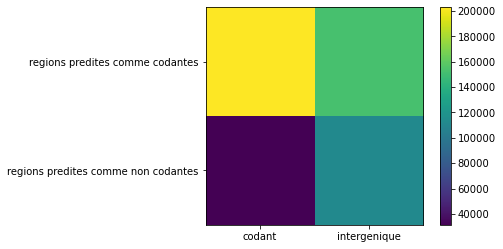

In [86]:
mat_conf=create_confusion_matrix(annotation_test, etat_predits)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 2, 1));
ax.set_yticks(np.arange(0, 2, 1));

# Labels for major ticks
ax.set_xticklabels(['codant','intergenique']);
ax.set_yticklabels(['regions predites comme codantes','regions predites comme non codantes']);

print(mat_conf)
plt.show()


Donner une interprétation.
Peut-on utiliser ce modèle pour prédire la position des gènes dans le génome ?

In [87]:
TP,FP=mat_conf[0] 
FN,TN=mat_conf[1] 

## Question 5 :  Génération de nouvelles séquences

En utilisant le modèle $ \lambda=\{Pi,A,B\}$, créer ` create_seq(N,Pi,A,B) ` une fonction permettant de générer :
- une séquence d'états cachés
- une sequence d'observations.

In [88]:
def create_seq(N,Pi,A,B):
    
    Pi_sc = np.cumsum(Pi)
    t = np.random.uniform(0, 1)
    st = np.argmax(Pi_sc > t)
    
    
    
    sequence_etats = np.zeros(N)
    sequence_obs = np.zeros(N)
    for i in range(N):
        sequence_etats[i] = st
        B_sc = np.cumsum(B[st])
        t = np.random.uniform(0, 1)
        ot = np.argmax(B_sc > t)
        sequence_obs[i] = ot
        
        A_i = A[st]
        A_i_sc = np.cumsum(A_i) 
        t = np.random.uniform(0, 1)
        st = np.argmax(A_i_sc > t)
        
    return sequence_etats ,sequence_obs

print(create_seq(20000,Pi,A,B))

(array([0., 0., 0., ..., 1., 2., 3.]), array([3., 3., 0., ..., 0., 3., 3.]))


## Question 6 : Construction d'un nouveau modèle

Évaluons maintenant si cela s'améliore en prenant en compte les frontières des gènes en construisant un modèle avec codon start et codon stop.
On veut maintenant d'intégrer l'information complémentaire qui dit qu'un gène commence "toujours" par un codon start et finit "toujours" par un codon stop avec le graphe de transition ci-dessous.

On considère donc maintenant un modèle à 12 états cachés.
![](modele2.png)


- Écrivez la matrice de transition correspondante, en mettant les probabilités de transition entre lettres pour les codons stop à 0.5.


- Adaptez la matrice des émissions pour tous les états du modèle. Vous pouvez réutiliser la matrice B, calculée précédement. Les états correspondant au codons stop n'émettrons qu'une seule lettre avec une probabilité $1$.
Pour le codon start, on sait que les proportions sont les suivantes: 

    - ATG : 83%, 
    - GTG: 14%,     
    - TTG: 3%

```python
Pi2 = np.array(   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ])  ##on commence encore dans l'intergenique
A2 =  np.array([[1-a, a, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                [0  , 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                  ... ])
B2 = ...

```


In [124]:
annotation_train_2 = annotation_train.copy()
annotation_train_2[np.where(annotation_train_2 == 1 )] = 4
annotation_train_2[np.where(annotation_train_2 == 2 )] = 5    
annotation_train_2[np.where(annotation_train_2 == 3 )] = 6
i = np.where(annotation_train_2 != 0)[0][0]
print(annotation_train[499980:500000])
while i < annotation_train_2.shape[0]:
    if(annotation_train_2[i] != 0):
        annotation_train_2[i] = 1
        annotation_train_2[i+1] = 2
        annotation_train_2[i+2] = 3
        i = i + 3
        while i < annotation_train_2.shape[0] and annotation_train_2[i] != 0:
            i = i+1
        if  annotation_train_2[i] == 0:
            if genome_train[i - 1] == 0:
                annotation_train_2[i - 1] = 10
            if genome_train[i - 1] == 2:
                annotation_train_2[i - 1] = 11

            if genome_train[i - 2] == 2:
                annotation_train_2[i - 2] = 8
            if genome_train[i - 2] == 0:
                annotation_train_2[i - 2] = 9  
            annotation_train_2[i - 3] = 7
            i = i + 1
    else:
        i = i + 1
#if(annotation_train_2[i] == 0 and annotation_train_2[i - 1] != 0): 
print(np.where(annotation_train_2 == 7, 1, 0).sum())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
239


In [127]:
def learnHMM_2(allx, allq, N, K):
    """ apprend un modèle à partir 
    d'un ensemble de couples (seq. d'observations, seq. d'états) 
    retourne les matrices A  B """
    A = np.zeros((N, N)) 
    B = np.zeros((N, K))
    ta = np.where(allq[0 : allq.shape[0] - 1] == 0, 1, 0).sum()
    tb = np.where(allq[0 : allq.shape[0] - 1] == 6, 1, 0).sum()
   
    a = 0
    b = 0
    for i in range(allq.shape[0] - 1):
        if allq[i] == 0 and allq[i+1] == 1:
            a = a + 1
        if allq[i] == 6 and allq[i+1] == 7 :
            b = b + 1
    a = a/ta
    b = b/tb
    A =  np.array(np.array([[1-a, a, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                            [0  , 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                            [0  , 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0 ],
                            [0  , 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0 ],
                            [0  , 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0 ],
                            [0  , 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0 ],
                            [0  , 0, 0, 0,1-b, 0, 0,b, 0, 0, 0, 0 ],
                            [0  , 0, 0, 0, 0, 0, 0, 0,0.5,0.5,0, 0 ],
                            [0  , 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0 ],
                            [0  , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5 ],
                            [1  , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                            [1  , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]]
                                      ))    
    for i in range (N):
        allx_i = allx[allq == i]
        for j in range(K):
            B[i, j] = np.where(allx_i == j, 1, 0).sum()/allx_i.shape[0]
            
    return A, B

In [130]:
Pi2 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
nb_etat= 12 ## (intergénique, condon 0, codon 1, condon 2)
nb_observation = 4 ## (A,T,C,G)
A2,B2 =learnHMM_2(genome_train, annotation_train_2, nb_etat, nb_observation)
print(A)
print(B)

[[0.99899016 0.00100984 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.99726288 0.
  0.         0.00273712 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.5        0.

Évaluez les performances du nouveau modèle en faisant de nouvelles predictions d'annotation pour genome_test, et comparez les avec le modèle précédent. 
```
etat_predits2=viterbi(genome_test,Pi2,A2,B2)
etat_predits2[etat_predits2!=0]=1 
```

```python

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits, label="prediction model1", ls="--")
ax.plot(etat_predits2, label="prediction model2", ls="--")

plt.legend(loc="best")
plt.show()
```

Calculer la matrice de confusion avec les nouvelles prédictions.

In [132]:
etat_predits_2 = viterbi(genome_test,Pi2,A2,B2)

<ipython-input-44-8d578060fd8e>:21: RuntimeWarning: divide by zero encountered in log
  delta[i, 0] = np.log(Pi[i]) + np.log(B[ i, allx[0]])
<ipython-input-44-8d578060fd8e>:24: RuntimeWarning: divide by zero encountered in log
  delta[j, t] = np.max(delta[:, t-1] + np.log(A[:, j]) ) + np.log(B[j, allx[t]])
<ipython-input-44-8d578060fd8e>:25: RuntimeWarning: divide by zero encountered in log
  psi[j, t] = np.argmax(delta[:, t-1] + np.log(A[:, j]))


In [133]:
annotation_test_2 = annotation_test.copy()
annotation_test_2[np.where(annotation_test_2 == 1 )] = 4
annotation_test_2[np.where(annotation_test_2 == 2 )] = 5    
annotation_test_2[np.where(annotation_test_2 == 3 )] = 6
i = np.where(annotation_test_2 != 0)[0][0]
while i < annotation_test_2.shape[0]:
    if(annotation_test_2[i] != 0):
        annotation_test_2[i] = 1
        annotation_test_2[i+1] = 2
        annotation_test_2[i+2] = 3
        i = i + 3
        while i < annotation_test_2.shape[0] and annotation_test_2[i] != 0:
            i = i+1
        if  annotation_test_2[i] == 0:
            if genome_test[i - 1] == 0:
                annotation_test_2[i - 1] = 10
            if genome_test[i - 1] == 2:
                annotation_test_2[i - 1] = 11

            if genome_test[i - 2] == 2:
                annotation_test_2[i - 2] = 8
            if genome_test[i - 2] == 0:
                annotation_test_2[i - 2] = 9  
            annotation_test_2[i - 3] = 7
            i = i + 1
    else:
        i = i + 1
#if(annotation_train_2[i] == 0 and annotation_train_2[i - 1] != 0): 


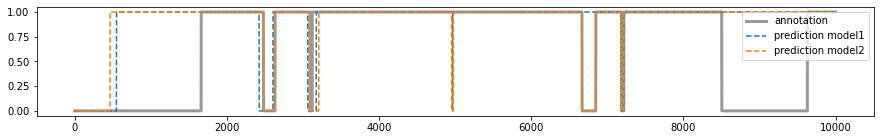

In [144]:
etat_predits2 = etat_predits_2.copy()
annotation_test2 = annotation_test_2.copy()

etat_predits2[etat_predits2!=0] = 1
annotation_test2[annotation_test2!=0]=1

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test2[30000:40000], label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits[30000:40000], label="prediction model1", ls="--")
ax.plot(etat_predits2[30000:40000], label="prediction model2", ls="--")

plt.legend(loc="best")
plt.show()

[[210662. 161458.]
 [ 23617. 104263.]]


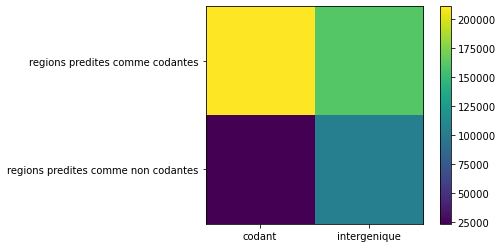

In [143]:
mat_conf2=create_confusion_matrix(annotation_test2, etat_predits2)
plt.imshow(mat_conf2)
plt.colorbar()
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 2, 1));
ax.set_yticks(np.arange(0, 2, 1));

# Labels for major ticks
ax.set_xticklabels(['codant','intergenique']);
ax.set_yticklabels(['regions predites comme codantes','regions predites comme non codantes']);

print(mat_conf2)
plt.show()

